In [ ]:
# 1) Imports & config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import json
import logging
import os
# Optional Firebase admin
import firebase_admin
from firebase_admin import credentials, storage

# Config - adjust paths if needed
SNAPSHOT_FOLDER = Path("output/runtime")     # Where 05 saves runtime_suggestions_*.csv
BUFFER_FILE     = SNAPSHOT_FOLDER / "hour_buffer.csv"  # rolling buffer file (local)
OUTPUT_FOLDER   = Path("output/hourly")              # where hourly outputs will be written locally
KEEP_MINUTES    = 60                            # rolling window in minutes
SNAPSHOT_PERIOD = 10                            # minutes (how frequently snapshots are taken)
TOP_N = 5                                       # number of top trending symbols to surface
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

# Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")


In [30]:
def append_snapshot_to_buffer(snapshot_file, buffer_file=BUFFER_FILE):
    df_rec = snapshot_to_records(snapshot_file)
    if df_rec.empty:
        return 0
    
    if "symbol" not in df_rec.columns:
        logging.warning(f"No symbol column in {snapshot_file}, skipping")
        return 0
    
    if buffer_file.exists():
        buffer_df = pd.read_csv(buffer_file)
    else:
        buffer_df = pd.DataFrame()
    
    # append and dedupe by (snapshot_ts, symbol)
    buf = pd.concat([buffer_df, df_rec], ignore_index=True, sort=False)
    buf.drop_duplicates(subset=["snapshot_ts","symbol"], inplace=True)
    
    # keep only last KEEP_MINUTES minutes
    cutoff = datetime.now() - timedelta(minutes=KEEP_MINUTES)
    buf["snapshot_ts"] = pd.to_datetime(buf["snapshot_ts"], errors='coerce')
    buf = buf.loc[buf["snapshot_ts"] >= cutoff].copy()
    
    buf.to_csv(buffer_file, index=False)
    logging.info(f"Appended snapshot {snapshot_file.name} to buffer. Buffer rows: {len(buf)}")
    return len(df_rec)

def snapshot_to_records(snapshot_file):
    df = pd.read_csv(snapshot_file)
    
    if df.empty:
        return pd.DataFrame()
    
    # extract timestamp from filename
    try:
        ts_text = snapshot_file.stem.split("_")[-1]
        ts = datetime.strptime(ts_text, "%Y%m%d%H%M%S")
    except:
        ts = datetime.now()
    
    df["snapshot_ts"] = ts
    return df


In [34]:
 # -------------------------
# 3) Compute hourly trends from latest snapshot
# -------------------------

# Get the latest snapshot CSV
snapshot_files = sorted(SNAPSHOT_FOLDER.glob("runtime_suggestions_*.csv"), reverse=True)
if not snapshot_files:
    logging.warning(f"No snapshot files found in {SNAPSHOT_FOLDER}. Skipping trend computation.")
    buf = pd.DataFrame()  # empty placeholder
else:
    latest_snapshot = snapshot_files[0]
    logging.info(f"Using latest snapshot: {latest_snapshot.name}")
    buf = pd.read_csv(latest_snapshot)
    
    # Ensure snapshot_ts column exists
    try:
        ts_text = latest_snapshot.stem.split("_")[-1]
        snapshot_ts = datetime.strptime(ts_text, "%Y%m%d%H%M%S")
    except:
        snapshot_ts = datetime.now()
    buf["snapshot_ts"] = snapshot_ts

# Check if buffer has data
if buf.empty:
    logging.warning("Snapshot is empty — skipping trend computation.")

# Normalize missing columns
for col in ["HotScore_today", "RuntimeScore", "regularMarketPrice",
            "regularMarketVolume", "ma50"]:
    if col not in buf.columns:
        buf[col] = np.nan

# Compute per-symbol trends
trend_rows = []
grouped = buf.groupby("symbol")

for symbol, g in grouped:
    g = g.sort_values("snapshot_ts")
    appearances = g["snapshot_ts"].nunique()

    first_hot = g["HotScore_today"].iloc[0] if not g["HotScore_today"].isna().all() else 0
    last_hot  = g["HotScore_today"].iloc[-1] if not g["HotScore_today"].isna().all() else 0
    trend_accel = last_hot - first_hot

    mean_runtime = g["RuntimeScore"].mean(skipna=True)
    last_price   = g["regularMarketPrice"].iloc[-1] if not g["regularMarketPrice"].isna().all() else np.nan

    last_vol = g["regularMarketVolume"].iloc[-1] if not g["regularMarketVolume"].isna().all() else np.nan
    mean_vol = g["regularMarketVolume"].mean(skipna=True)
    rvol = (last_vol / mean_vol) if mean_vol and not np.isnan(mean_vol) else 0

    ma50 = g["ma50"].iloc[-1] if "ma50" in g.columns and not g["ma50"].isna().all() else np.nan
    is_above_ma50 = 1 if (not np.isnan(last_price) and not np.isnan(ma50) and last_price > ma50) else 0

    # Rank score: times in top 10% by RuntimeScore
    top_counts = (g["RuntimeScore"] >= g["RuntimeScore"].quantile(0.9)).sum()
    
    trend_rows.append({
        "symbol": symbol,
        "appearances": appearances,
        "first_hot": first_hot,
        "last_hot": last_hot,
        "trend_accel": float(trend_accel),
        "mean_runtime": float(mean_runtime) if not np.isnan(mean_runtime) else 0,
        "last_price": float(last_price) if not np.isnan(last_price) else np.nan,
        "rvol": float(rvol),
        "is_above_ma50": int(is_above_ma50),
        "rank_score": int(top_counts)
    })

# Create trend DataFrame
trend_df = pd.DataFrame(trend_rows).set_index("symbol")

# Compute final trend score
trend_df = trend_df.fillna(0)
trend_df["trend_score"] = (
    2.0 * trend_df["appearances"] +
    3.0 * trend_df["trend_accel"] +
    1.5 * trend_df["rvol"] +
    2.0 * trend_df["is_above_ma50"] +
    2.0 * trend_df["rank_score"]
)

trend_df = trend_df.sort_values("trend_score", ascending=False)
trend_df.head(10)


2025-11-24 20:23:28,765 INFO Using latest snapshot: runtime_suggestions_20251124143948.csv


,appearances,first_hot,last_hot,trend_accel,mean_runtime,last_price,rvol,is_above_ma50,rank_score,trend_score
symbol,,,,,,,,,,
ADPT,1,0.868842,0.868842,0.0,0.959882,18.61,1.0,0,1,5.5
BLTE,1,0.977053,0.977053,0.0,1.011380,120.56,1.0,0,1,5.5
GRAL,1,0.921789,0.921789,0.0,1.011066,93.55,1.0,0,1,5.5
HTFL,1,0.889474,0.889474,0.0,0.969438,30.85,1.0,0,1,5.5
LITE,1,0.935474,0.935474,0.0,0.997892,255.59,1.0,0,1,5.5
MOG-A,1,0.968632,0.968632,0.0,0.984316,214.77,1.0,0,1,5.5
OSIS,1,0.924842,0.924842,0.0,0.962421,251.10,1.0,0,1,5.5
PODD,1,0.898000,0.898000,0.0,0.979218,331.17,1.0,0,1,5.5
RH,1,0.857263,0.857263,0.0,0.969214,153.08,1.0,0,1,5.5


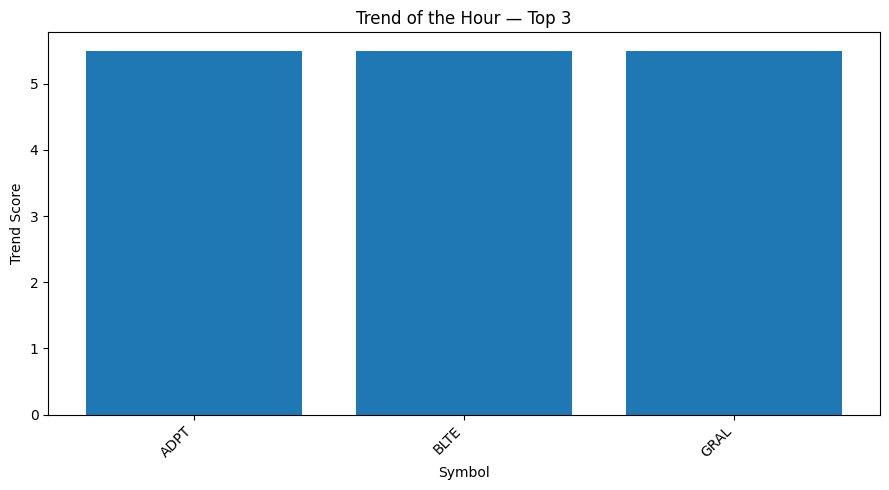

2025-11-24 20:34:33,462 INFO Saved trend PNG: output\hourly\hour_trend_20251124203433.png
2025-11-24 20:34:33,471 INFO Saved HTML report: output\hourly\hour_trend_20251124203433.html
2025-11-24 20:34:33,477 INFO Saved metadata JSON: output\hourly\metadata_hour_trend_20251124203433.json


In [ ]:
# 5) Save outputs (HTML, PNG, JSON)
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

png_out = OUTPUT_FOLDER / f"hour_trend_{timestamp}.png"
html_out = OUTPUT_FOLDER / f"hour_trend_{timestamp}.html"
meta_out = OUTPUT_FOLDER / f"metadata_hour_trend_{timestamp}.json"

# Chart: top TOP_N
topN = trend_df.head(TOP_N).reset_index()

if len(topN) > 0:
    plt.figure(figsize=(9, 5))
    plt.bar(topN["symbol"], topN["trend_score"])
    plt.title(f"Trend of the Hour — Top {TOP_N}")
    plt.ylabel("Trend Score")
    plt.xlabel("Symbol")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(png_out, dpi=200)
    plt.close()
else:
    # Create an empty placeholder PNG
    plt.figure(figsize=(6, 3))
    plt.text(0.5, 0.5, "No Data Available", ha="center", va="center", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(png_out, dpi=200)
    plt.close()

logging.info(f"Saved trend PNG: {png_out}")

# Build HTML report
rel_png_path = png_out.name  # PNG is in same folder as HTML

html_parts = [
    f"<h1>Hourly Trend Report — {timestamp}</h1>",
    "<h2>Top Symbols Table</h2>",
    trend_df.head(TOP_N).to_html(
        index=True, classes='table table-sm', border=0
    ),
    "<h2>Trend Score Chart</h2>",
    f'<img src="{rel_png_path}" alt="Trend chart" style="max-width:100%;">'
]

with open(html_out, "w", encoding="utf-8") as fh:
    fh.write("<html><head><meta charset='utf-8'><title>Hourly Trend</title></head><body>")
    fh.write("\n".join(html_parts))
    fh.write("</body></html>")

logging.info(f"Saved HTML report: {html_out}")

# Metadata
meta = {
    "timestamp": timestamp,
    "top_symbols": topN["symbol"].tolist(),
    "counts": int(len(trend_df)),
    "files": {
        "html": html_out.name,
        "png": png_out.name
    }
}

with open(meta_out, "w") as f:
    json.dump(meta, f, indent=2)

logging.info(f"Saved metadata JSON: {meta_out}")
